<a href="https://colab.research.google.com/github/byiringiroscar/NLP_FELLOWSHIP/blob/main/OscarByiringiroAssignmentRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir("/content/drive/MyDrive/NLP Fellowship/huzalab_doc/")

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
#Required libraries Import
import numpy as np
import pandas as pd

import unicodedata, re, string
import nltk

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt

In [5]:
#Reading training and testing dataset that we got from Kaggle
df_train = pd.read_csv("train.tsv", sep="\t")
df_test = pd.read_csv("test.tsv", sep="\t")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [7]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
df_train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


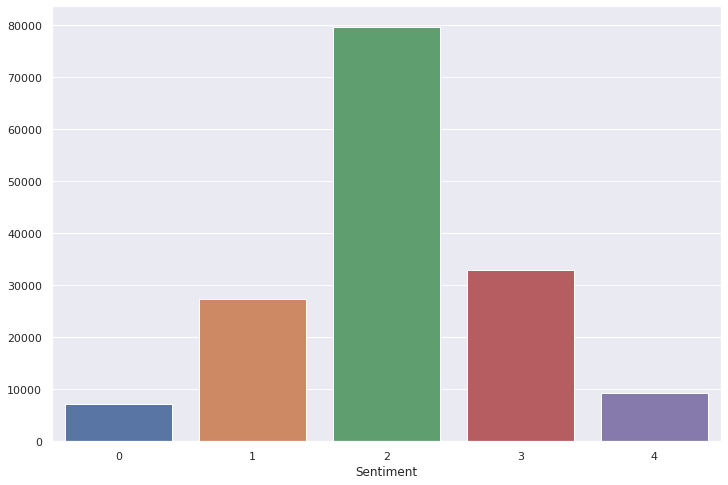

In [9]:
dist = df_train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

In [10]:
#Data Preprocessing
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# First step - tokenizing phrases
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)

# Second step - passing through prep functions
df_train['Words'] = df_train['Words'].apply(normalize) 
df_train['Words'].head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Words, dtype: object

In [13]:
# Third step - creating a list of unique words to be used as dictionary for encoding
word_set = set()
for l in df_train['Words']:
    for e in l:
        word_set.add(e)
        
word_to_int = {word: ii for ii, word in enumerate(word_set, 1)}

# Check if they are still the same lenght
print(len(word_set))
print(len(word_to_int))

16209
16209


In [14]:
# Now the dict to tokenize each phrase
df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
df_train['Tokens'].head()

0    [8540, 7987, 3915, 9983, 15267, 632, 298, 1236...
1    [8540, 7987, 3915, 9983, 15267, 632, 298, 1236...
2                                         [8540, 7987]
3                                               [8540]
4                                               [7987]
Name: Tokens, dtype: object

In [15]:
# Step four - get the len of longest phrase
max_len = df_train['Tokens'].str.len().max()
print(max_len)

48


In [16]:
#Performing one-hot-encoding
all_tokens = np.array([t for t in df_train['Tokens']])
encoded_labels = np.array([l for l in df_train['Sentiment']])

# Create blank rows
features = np.zeros((len(all_tokens), max_len), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

#print first 3 values of the feature matrix 
print(features[:3])

<ipython-input-16-e66753ac1872>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_tokens = np.array([t for t in df_train['Tokens']])


[[ 8540  7987  3915  9983 15267   632   298 12360  8528  7988  2836 11382
    632 10703  7988  2877  2836 11382   632  4629  7890  3915  8808  4833
   5722  8994 11874  3915  8808  1805  3001 14317  3915  8540  2944     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 8540  7987  3915  9983 15267   632   298 12360  8528  7988  2836 11382
    632 10703     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 8540  7987     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [17]:
split_frac = 0.9

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
X_train, X_remaining = features[:split_idx], features[split_idx:]
Y_train, Y_remaining = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(X_remaining)*0.5)
X_val, X_test = X_remaining[:test_idx], X_remaining[test_idx:]
Y_val, Y_test = Y_remaining[:test_idx], Y_remaining[test_idx:]

## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(X_train.shape), 
      "\nValidation set: \t{}".format(X_val.shape),
      "\nTest set: \t\t{}".format(X_test.shape))

			Feature Shapes:
Train set: 		(124848, 48) 
Validation set: 	(15606, 48) 
Test set: 		(15606, 48)


In [18]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))

# dataloaders
batch_size = 54

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Check the size of the loaders (how many batches inside)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

2312
289
289


In [19]:
# First checking if GPU is available before training a RNN model
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [20]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.3):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        
        # linear
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)

        # transform lstm output to input size of linear layers
        lstm_out = lstm_out.transpose(0,1)
        lstm_out = lstm_out[-1]

        out = self.dropout(lstm_out)
        out = self.fc(out)        

        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [21]:
# Instantiate the model w/ hyperparams
vocab_size = len(word_to_int)+1 # +1 for the 0 padding
output_size = 6
embedding_dim = 300
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(16210, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


In [22]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [23]:
# training params
epochs = 2 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 200
clip=4 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/2... Step: 200... Loss: 1.294140... Val Loss: 1.305226
Epoch: 1/2... Step: 400... Loss: 1.272222... Val Loss: 1.305099
Epoch: 1/2... Step: 600... Loss: 1.430991... Val Loss: 1.301432
Epoch: 1/2... Step: 800... Loss: 1.474574... Val Loss: 1.308065
Epoch: 1/2... Step: 1000... Loss: 1.162888... Val Loss: 1.252559
Epoch: 1/2... Step: 1200... Loss: 1.149797... Val Loss: 1.238854
Epoch: 1/2... Step: 1400... Loss: 1.163051... Val Loss: 1.207795
Epoch: 1/2... Step: 1600... Loss: 1.112455... Val Loss: 1.195357
Epoch: 1/2... Step: 1800... Loss: 0.887349... Val Loss: 1.183152
Epoch: 1/2... Step: 2000... Loss: 1.065301... Val Loss: 1.167127
Epoch: 1/2... Step: 2200... Loss: 0.932817... Val Loss: 1.147191
Epoch: 2/2... Step: 2400... Loss: 1.012868... Val Loss: 1.155472
Epoch: 2/2... Step: 2600... Loss: 0.870234... Val Loss: 1.130427
Epoch: 2/2... Step: 2800... Loss: 1.005062... Val Loss: 1.115527
Epoch: 2/2... Step: 3000... Loss: 0.769129... Val Loss: 1.094013
Epoch: 2/2... Step: 3200... L

In [24]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output,1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc*100)+" %")

Test loss: 1.074
Test accuracy: 57.068 %
